In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import h5py
import pandas as pd
from skimage.transform import rescale 
from mpl_toolkits.mplot3d import Axes3D

# Cutting up a HEALPix map

We would like to impose a Galactic cut, and split the remaining sky into equal size patches. 

$$
\theta_s = (\theta_0 \times s) \\
\phi_s = \phi_0 + s
$$

The Galactic cut of 15 degrees.

$$
d
$$

Generating fixed 500 points on a sphere centered at the origin


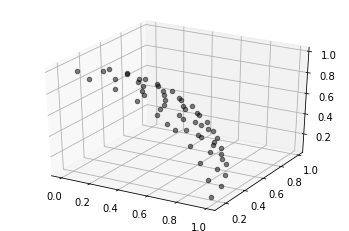

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n = 500
print("Generating fixed %d points on a sphere centered at the origin" % (n))
r = 1
alpha = 4.0*np.pi*r*r/n
d = np.sqrt(alpha)
m_nu = int(np.round(np.pi/d))
d_nu = np.pi/m_nu
d_phi = alpha/d_nu
count = 0
for m in range (0,m_nu):
    nu = np.pi*(m+0.5)/m_nu
    m_phi = int(np.round(2*np.pi*np.sin(nu)/d_phi))
    for n in range (0,m_phi):
        phi = 2*np.pi*n/m_phi
        xp = r*np.sin(nu)*np.cos(phi)
        yp = r*np.sin(nu)*np.sin(phi)
        zp = r*np.cos(nu)
        if (xp > 0) and (yp > 0) and (zp > 0):
            ax.scatter(xp, yp, zp, color='k', alpha=0.5)
        count = count +1


# Forming the $T,~\psi \rightarrow Q,~U$ simulations

In [16]:
def temp_ang_to_qu(pol_frac, angle, temp):
    """ Function to calculate a Q, U pair of maps from temperature and 
    polarization angle.
    """
    try:
        assert temp.ndim == 1
        assert angle.ndim == 1
    except AssertionError:
        raise AssertionError("`temp` or `angle` has more than one dimension")
    pol = np.zeros((2, len(pol_frac)))
    pol[0] = np.cos(2. * angle) * pol_frac * temp
    pol[1] = np.sin(2. * angle) * pol_frac * temp
    return pol

def get_pol_ang(q, u):
    return 0.5 * np.arctan2(u, q)

def get_pol_frac(t, q, u):
    return np.sqrt(q ** 2 + u ** 2) / t

In [18]:
nside = 512

t, q, u = hp.ud_grade(hp.read_map("/home/bthorne/projects/gan/began/data/raw/data/COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits", field=(0, 1, 2)), nside_out=nside, verbose=False)

tsmo, qsmo, usmo = hp.smoothing((t, q, u), fwhm=2. * np.pi / 180., verbose=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/bthorne/projects/gan/began/data/raw/data/COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits'

In [7]:
pol_angle = get_pol_ang(q, u)
pol_frac = get_pol_frac(tsmo, qsmo, usmo)
qu_sim = temp_ang_to_qu(pol_frac, pol_angle, t)

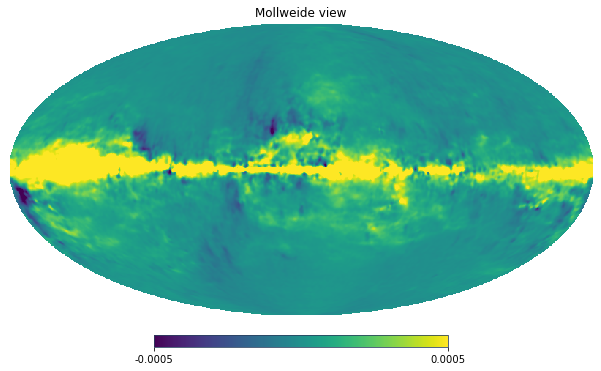

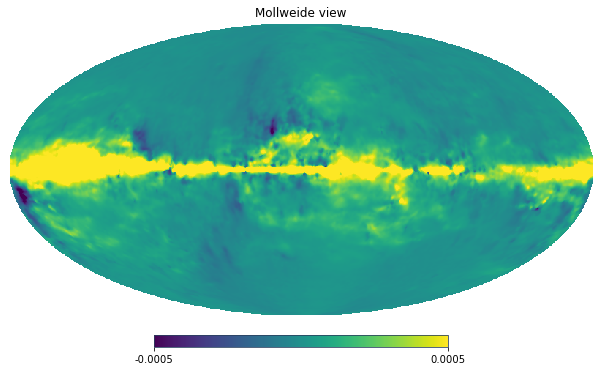

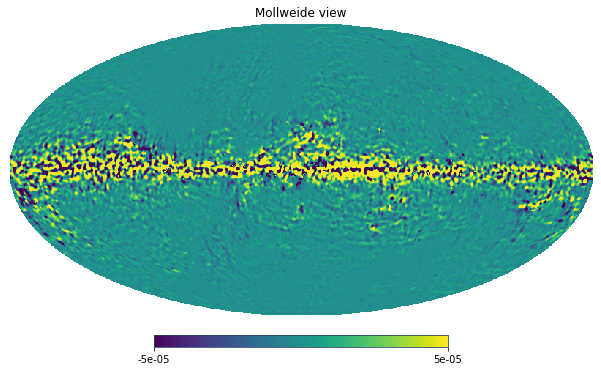

In [46]:
hp.mollview(q, min=-0.0005, max=0.0005)
hp.mollview(qu_sim[0], min=-0.0005, max=0.0005)
hp.mollview(q - qu_sim[0], min=-0.00005, max=0.00005)

In [ ]:
hp.cartview(t, coord=['G', 'E'], lonra=[-20, 20], latra=[-10, 10], norm='log')
img = hp.cartview(q, coord=['G', 'E'], lonra=[-20, 20], latra=[-10, 10], min=-1e-5, max=1e-4, return_projected_map=True)
hp.cartview(qu_sim[0], coord=['G', 'E'], lonra=[-20, 20], min=-1e-5, max=1e-4, latra=[-10, 10])

# Statistics of simualted maps

We first define a small sky region at high latitude to look at ($\theta_{\rm colat}=0.5, \phi=0$), radius $0.5$ radians.

In [116]:
mask = np.zeros_like(t)
theta = 0.5
phi = 0.
radius = 0.5
idx = hp.query_disc(nside, hp.ang2vec(theta, phi), radius)
mask[idx] = 1

## Pixel intensity histogram

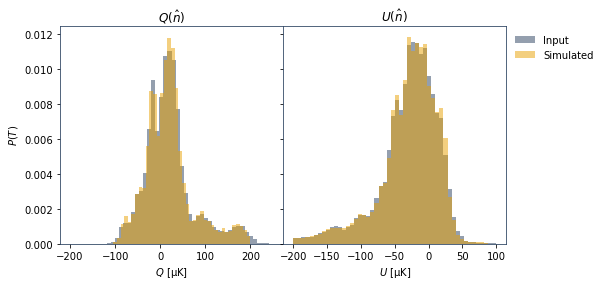

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
plt.subplots_adjust(wspace=0)
ax[0].set_title(r"$Q(\hat n)$")
ax[1].set_title(r"$U(\hat n)$")

ax[0].set_ylabel(r"$P(T)$")
ax[0].set_xlabel(r"$Q~[\rm \mu K]$")
ax[1].set_xlabel(r"$U~[\rm \mu K]$")

ax[0].hist(1e6 * q[mask != 0], bins=50, range=[-200, 250], alpha=0.5, density=True)
ax[0].hist(1e6 * qu_sim[0][mask != 0], bins=50, range=[-200, 200], alpha=0.5, density=True)

ax[1].hist(1e6 * u[mask != 0], bins=50, range=[-200, 100], alpha=0.5, density=True, label=r"Input")
ax[1].hist(1e6 * qu_sim[1][mask != 0], bins=50, range=[-200, 100], alpha=0.5, density=True, label=r"Simulated")

ax[1].legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
fig.savefig("plots/pixel_intensity_hist_GNILC_sim.png", bbox_inches='tight', dpi=400)

## Power spectrum of simulations

In [10]:
import pymaster as nmt

In [101]:
apo_mask = nmt.mask_apodization(mask, aposize=5., apotype='C1')
print(np.mean(apo_mask))

0.051315393686704756


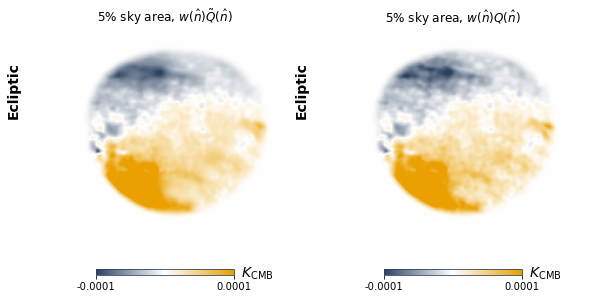

In [111]:
#hp.mollview(apo_mask * q, title=r"$w(\hat n) Q(\hat n)$", cmap=mycmap)
#hp.mollview(apo_mask * qu_sim[0], title=r"$w(\hat n) Q(\hat n)$", cmap=mycmap)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for a in ax:
    a.axis('off')
hp.cartview(apo_mask * qu_sim[0], min=-0.0001, max=0.0001, sub=121, coord=['G', 'E'],lonra=[170, 260], latra=[(theta - 1.5*radius) * 180. / np.pi, (theta + radius) * 180. / np.pi], cmap=mycmap, title=r"5% sky area, $w(\hat n)\tilde Q(\hat n)$", unit=r"$K_{\rm CMB}$")
hp.cartview(apo_mask * q, min=-0.0001, max=0.0001, sub=122, coord=['G', 'E'],lonra=[170, 260], latra=[(theta - 1.5*radius) * 180. / np.pi, (theta + radius) * 180. / np.pi], cmap=mycmap, title=r"5% sky area, $w(\hat n)Q(\hat n)$", unit=r"$K_{\rm CMB}$")
fig.savefig("plots/map_comparison_GNILC_sim.png", bbox_inches='tight', dpi=400)

In [51]:
f2_qu = nmt.NmtField(apo_mask, [q, u], purify_b=True, purify_e=True)

In [52]:
f2_qu_sim = nmt.NmtField(apo_mask, [qu_sim[0], qu_sim[1]], purify_b=True, purify_e=True)

In [53]:
bins = nmt.NmtBin(nside, nlb=20)

In [54]:
w22 = nmt.NmtWorkspace()

In [55]:
w22.compute_coupling_matrix(f2_qu, f2_qu, bins)

In [56]:
cl_qu_in = w22.decouple_cell(nmt.compute_coupled_cell(f2_qu, f2_qu))
cl_qu_sim = w22.decouple_cell(nmt.compute_coupled_cell(f2_qu_sim, f2_qu_sim))

In [114]:
ells = bins.get_effective_ells()
dl_in = cl_qu_in * ells[None, :] ** 2 / 2. / np.pi * 1e12
dl_sim = cl_qu_sim * ells[None, :] ** 2 / 2. / np.pi * 1e12

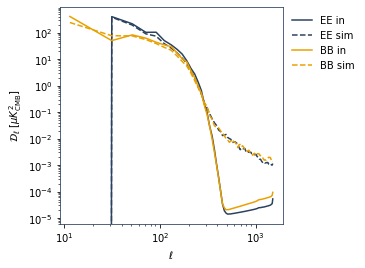

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(ells, dl_in[0], 'C0-', label='EE in')
ax.loglog(ells, dl_sim[0], 'C0--', label='EE sim')
ax.loglog(ells, dl_in[3], 'C1-', label='BB in')
ax.loglog(ells, dl_sim[3], 'C1--', label='BB sim')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\mathcal{D}_\ell~[\mu K_{\rm CMB}^2]$")
fig.savefig("plots/pol_spectra_GNILC_sim.png", bbox_inches='tight', dpi=400)

# Preparing a training set

In this section we will prepare cutouts from the full-sky map to be projected into Cartesian coordinates. 

In [19]:
class MapCutter(object):
    """
    Map Cutter object: instantiate with a healpix map and use methods to convert units and produce cuts from desired map regions.
    """
    def __init__(self, map_to_cut):
        if isinstance(map_to_cut,str):
            self.map = hp.read_map(map_to_cut)
        else:
            
            self.map = map_to_cut

    
    def cut_map(self, rot, res=900, out_put_file = None):
        """
        Returns map cut from desired region from the given longitudinal and latitudinal ranges (assuming small engough for flat sky limit)"
        """
        map_cut = hp.cartview(self.map, rot=rot,lonra=[-10,10],latra=[-10,10],xsize=res,ysize=res,return_projected_map=True)
        plt.close()
        return map_cut
    
        if out_put_file != None:
            dump(map_cut,open(out_put_file,'wb'), protocol = -1)
            
MP = MapCutter("/home/bthorne/projects/gan/began/data/raw/HFI_SkyMap_545-field-Int_2048_R3.00_full.fits")
t = hp.read_map("/home/bthorne/projects/gan/began/data/raw/HFI_SkyMap_545-field-Int_2048_R3.00_full.fits")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/bthorne/projects/gan/began/envs/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [6]:
step = 5
galactic_cut = 20
map_cuts = []
log_means = []
log_vars = []
count=0
res = 256 / 1024
output_file_prefix = "/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353"

In [ ]:
lat_range = list(range(-90,-galactic_cut,step))+list(range(galactic_cut+step,95,step))
for j,theta in enumerate(lat_range):
    lon_range = np.arange(0,360,step/np.cos(theta/180.*np.pi))
    
    for i,phi in enumerate(lon_range):
        map_cut = rescale(MP.cut_map([phi,theta]),res,preserve_range=True,anti_aliasing=False)
        map_cuts.append(map_cut)
        with h5py.File(output_file_prefix, 'a') as hf:
            hf.create_dataset(str(count), data=map_cut)
        count+=1
    log_means.append(np.mean(np.log(map_cuts)))
    log_vars.append(np.var(np.log(map_cuts)))
    map_cuts = []
    print('Batch %d out of %s completed' %(j+1,len(lat_range)))

In [7]:
log_mean = np.mean(log_means)
log_var = np.mean(log_vars)

print('Create log-norm maps')
with h5py.File(output_file_prefix, 'r') as hfr:
    log_maps=np.log([i for i in hfr.values()])

Create log-norm maps


In [8]:
log_max =np.max(log_maps)
log_min = np.min(log_maps)

with h5py.File(output_file_prefix+'_log_norm_res256.h5', 'w') as hfw:
    for i,m in enumerate(log_maps):
        hfw.create_dataset(str(i),data=2*(m-log_min)/(log_max-log_min)-1)

In [ ]:
fig, axes = plt.subplots(30, 40, sharex=True, sharey=True, figsize=(30, 30))
plt.subplots_adjust(hspace=0)
with h5py.File(output_file_prefix+'_log_norm_res256.h5', 'r') as hfw:
    print(hfw['1'])
    for i, ax in enumerate(axes.flatten()):
        try:
            ax.imshow(hfw[str(i)])
        except KeyError:
            pass
fig.savefig("plots/cutout_samples.pdf")

In [18]:
print(data)

<Closed HDF5 dataset>


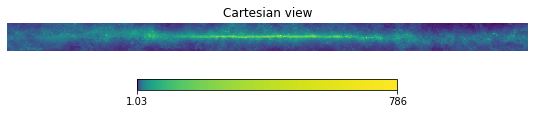

In [66]:
hp.cartview(t, lonra=[-180, 180], latra=[-10, 10], norm='log')

My vesion

In [26]:
lat_range = list(range(-90,-galactic_cut,step))+list(range(galactic_cut+step,95,step))
lon_range = [] 
for j,theta in enumerate(lat_range):
    lon_range.append(np.arange(0,360,step/np.cos(theta/180.*np.pi)))

In [68]:
256*256*1000

65536000

In [30]:
lon_range[2]

array([  0.        ,  28.79385242,  57.58770483,  86.38155725,
       115.17540966, 143.96926208, 172.76311449, 201.55696691,
       230.35081933, 259.14467174, 287.93852416, 316.73237657,
       345.52622899])

Rotations

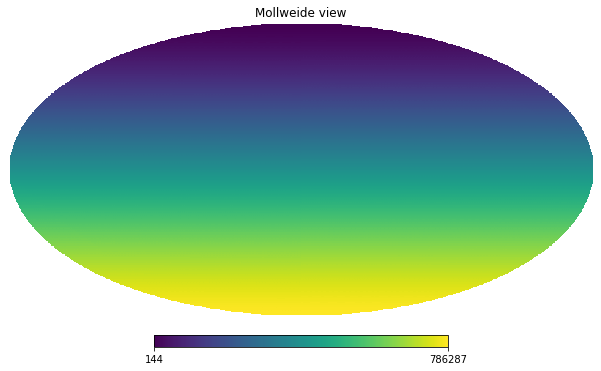

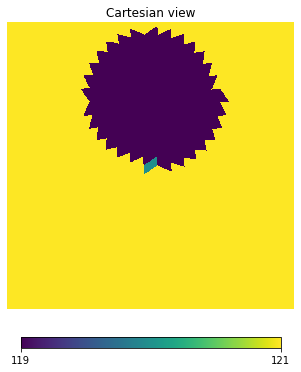

In [59]:
nside = 256
ma = np.arange(hp.nside2npix(nside))
hp.mollview(ma)
pix = hp.pix2ang(nside, 120, lonlat=True)
img = hp.cartview(ma, rot=pix, lonra=[-3, 3], latra=[-3, 3], min=119, max=121, return_projected_map=True)

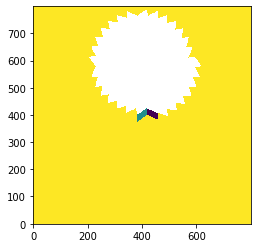

In [60]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img, origin='lower', interpolation='nearest', vmin=119, vmax=121)

In [70]:
arr = np.random.randn(1000, 256, 256)

In [72]:
arr.size * arr.itemsize / 1e9

0.524288